In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from mplcursors import cursor

In [3]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:  # No activation after the last layer
                self.hidden_layers.append(nn.Tanh())
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return x

    def model_forward(self, x):
        x.requires_grad = True
        p = self.forward(x)
        p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
        k_x_p_x = self.k(x) * p_x
        k_x_p_x_X = torch.autograd.grad(k_x_p_x, x, torch.ones_like(k_x_p_x), create_graph=True)[0]
        return p, k_x_p_x_X

    def loss_fn(self, p, k_x_p_x_X, x_bc):
        eq = -k_x_p_x_X - self.f(x_bc)
        bc_loss = torch.mean(p[0]**2) + torch.mean(p[-1]**2)
        return torch.mean(eq**2) + bc_loss

    def k(self, x):
        return 1/(4 + 1 * torch.sin(2*math.pi*x))

    def f(self, x):
        return torch.ones_like(x)

In [4]:
def exact_sol(x):
    return (-32*np.power(math.pi, 2)*np.power(x, 2) + 32*np.power(math.pi, 2)*x - 8*math.pi*x - 4*np.sin(2*math.pi*x) + (math.pi*(8*x-4)+1)*np.cos(2*math.pi*x)+4*math.pi-1)/(16*np.power(math.pi, 2))

In [5]:
# Define the network, training data, and optimizer
layers = [1, 50, 50, 50, 1] # NN architecture
model = PINN(layers)
x_train = torch.linspace(0, 1, 100).unsqueeze(1) # unflatten each value to array
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
n_epochs = 1000
loss_array = []

In [6]:
start_time = time.time()
loss = torch.tensor(1.)
epoch = 0
while loss.item() > math.pow(0.1, 4):
    optimizer.zero_grad()
    p, k_x_p_x_X = model.model_forward(x_train)
    loss = model.loss_fn(p, k_x_p_x_X, x_train)
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    epoch += 1

print("Training took %s seconds" % (time.time() - start_time))

Epoch 0, Loss: 1.028581142425537
Epoch 100, Loss: 0.05430658161640167
Training took 1.029102087020874 seconds


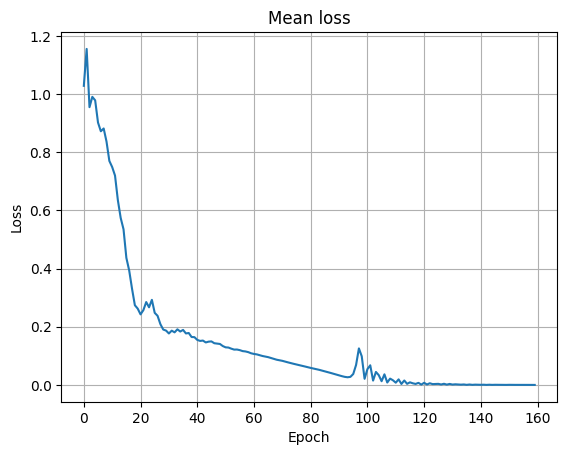

In [7]:
plt.plot(loss_array)
cursor(hover=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Mean loss')
plt.show(block=False)

# Solution visualization
x_test = torch.linspace(0, 1, 100).unsqueeze(1)
with torch.no_grad():
    p_pred = model(x_test).numpy()

x_test_exact = np.linspace(0, 1, 100)[:, np.newaxis]
p_exact = exact_sol(x_test_exact)

x_test_exact_2 = np.linspace(0, 1, 21)[:, np.newaxis]
p_exact_2 = exact_sol(x_test_exact_2)


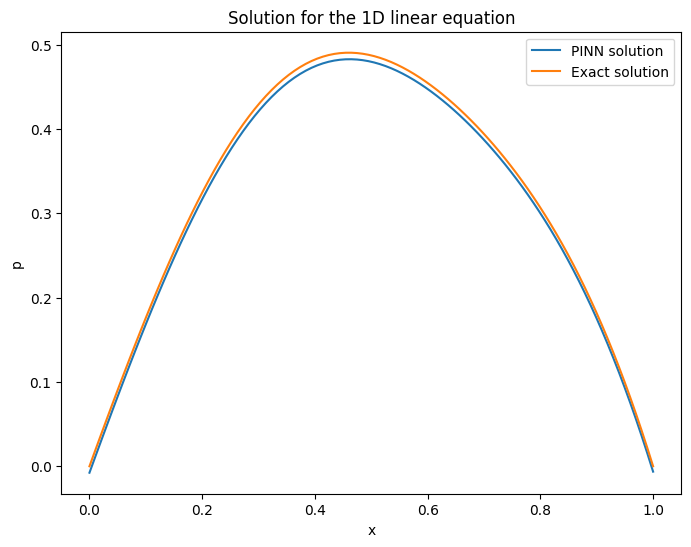

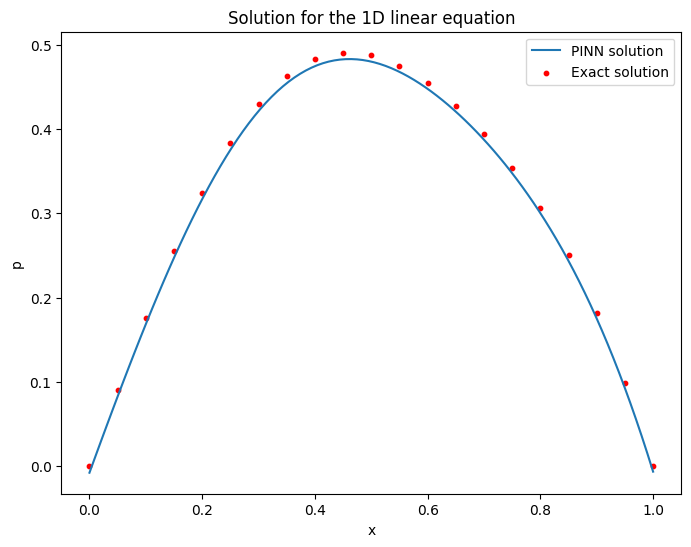

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(x_test, p_pred, label='PINN solution')
plt.plot(x_test, p_exact, label='Exact solution')
cursor(hover=True)
plt.xlabel('x')
plt.ylabel('p')
plt.title('Solution for the 1D linear equation')

plt.legend()
plt.show(block=False)

plt.figure(figsize=(8, 6))
plt.plot(x_test, p_pred, label='PINN solution')
plt.scatter(x_test_exact_2, p_exact_2, color='red', label='Exact solution', s=10)
cursor(hover=True)
plt.xlabel('x')
plt.ylabel('p')
plt.title('Solution for the 1D linear equation')

plt.legend()
plt.show()
